# Error estimation & adaptive refinement


In this tutorial, we apply a Zienkiewicz-Zhu type error estimator and run an adaptive loop with these steps:
$$
\text{Solve}\rightarrow
\text{Estimate}\rightarrow
\text{Mark}\rightarrow
\text{Refine}\rightarrow
\text{Solve} \rightarrow \ldots
$$

In [1]:
import netgen.gui
%gui tk
from ngsolve import *
from netgen.geom2d import SplineGeometry

### Geometry

The following geometry represents a heating chip imbedded in another material that conducts away the heat.

In [2]:
#   point numbers 0, 1, ... 11
#   sub-domain numbers (1), (2), (3)
#  
#
#             7-------------6
#             |             |
#             |     (2)     |
#             |             |
#      3------4-------------5------2
#      |                           |
#      |             11            |
#      |           /   \           |
#      |         10 (3) 9          |
#      |           \   /     (1)   |
#      |             8             |
#      |                           |
#      0---------------------------1
#

def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,2,1,0), (2,5,2,1,0), (5,4,2,1,2), (4,3,2,1,0), (3,0,2,1,0), \
              (5,6,2,2,0), (6,7,2,2,0), (7,4,2,2,0), \
              (8,9,2,3,1), (9,10,2,3,1), (10,11,2,3,1), (11,8,2,3,1) ]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append(["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)

    geometry.SetMaterial(1,"base")
    geometry.SetMaterial(2,"chip")
    geometry.SetMaterial(3,"top")    

    return geometry

mesh = Mesh(MakeGeometry().GenerateMesh(maxh=0.2))

### Spaces & forms

The problem is to find $u$ in $H_{0,D}^1$ satisfying 
$$
\int_\Omega \lambda \nabla u \cdot \nabla v = \int_\Omega f v 
$$
for all $v$ in $H_{0,D}^1$. We expect the solution to have singularities due to the nonconvex re-enrant angles and discontinuities in $\lambda$.

In [3]:
fes = H1(mesh, order=3, dirichlet=[1])
u = fes.TrialFunction()
v = fes.TestFunction()

# one heat conductivity coefficient per sub-domain
lam = CoefficientFunction([1, 1000, 10])
a = BilinearForm(fes)
a += SymbolicBFI(lam*grad(u)*grad(v))

# heat-source in inner subdomain
f = LinearForm(fes)
f += SymbolicLFI(CoefficientFunction([0, 0, 1])*v)

c = Preconditioner(a, type="multigrid", flags= {"inverse" : "sparsecholesky" })

gfu = GridFunction(fes)
Draw (gfu)

Note that the linear system is not yet assembled above.

### Solve 

Since we must solve multiple times, we define a function to solve the boundary value problem, where assembly, update, and solve occurs.

In [4]:
def SolveBVP():
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)

In [5]:
SolveBVP()

### Estimate

We implement a gradient-recovery-type error estimator. For this, we need an H(div) space for flux recovery. We must compute the flux  of the computed solution and interpolate it into this H(div) space.

In [6]:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

flux = lam * grad(gfu)
gf_flux.Set(flux)

In [7]:
err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
Draw(err, mesh, 'error_representation')

**Element-wise error estimator:** On each element $T$, set 
$$
\eta_T^2 = \int_T \frac{1}{\lambda} 
|\lambda \nabla u_h - I_h(\lambda \nabla u_h) |^2
$$
where $u_h$ is the computed solution `gfu` and $I_h$ is the interpolation performed by `Set` in NGSolve.


In [8]:
eta2 = Integrate(err, mesh, VOL, element_wise=True)
print(eta2)

 8.29527e-11
 2.76102e-08
 4.30874e-06
 5.51056e-11
 9.9237e-11
 1.04389e-07
 6.71168e-08
 2.05491e-07
 2.01376e-07
 9.10162e-09
 1.38102e-07
 2.59032e-07
 4.1139e-09
 6.38089e-11
 1.11165e-10
 1.93678e-07
 1.95124e-07
 2.19639e-07
 3.33617e-07
 1.9476e-10
 2.75099e-06
 2.82018e-06
 1.94308e-08
 7.23036e-11
 4.16706e-07
 3.51813e-09
 1.46782e-07
 7.35986e-08
 7.36518e-08
 2.54649e-06
 2.85403e-10
 2.37665e-10
 2.68309e-10
 8.94199e-10
 8.25576e-07
 5.43572e-07
 7.69331e-07
 4.0351e-07
 1.92988e-07
 2.0307e-07
 3.83832e-06
 9.16969e-10
 1.92183e-08
 7.10309e-09
 5.94227e-10
 1.7884e-09
 1.91099e-08
 1.66791e-08
 5.31563e-08
 1.36593e-08
 1.14483e-07
 3.58083e-08
 1.34567e-09
 1.56066e-10
 5.68704e-12
 4.02048e-12
 3.4852e-10
 5.74364e-13
 1.45869e-11
 5.91522e-12
 2.60765e-10
 7.07655e-07
 9.39162e-08



The above values, one per element, lead us to identify elements which might have large error.


### Mark 

We mark elements with large error estimator for refinement.

In [9]:
maxerr = max(eta2)
print ("maxerr = ", maxerr)

for el in mesh.Elements():
    mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)
    
Draw(gfu)

maxerr =  4.3087448225267724e-06


### Refine & solve again 

Refine marked elements:

In [10]:
mesh.Refine()
SolveBVP()
Redraw()

### Automate the above steps

In [11]:
l = []    # l = list of estimated total error

def CalcError():

    # compute the flux:
    space_flux.Update()      
    gf_flux.Update()
    flux = lam * grad(gfu)        
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " maxerr =", maxerr)
    
    # mark for refinement:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)

In [12]:
CalcError()
mesh.Refine()

ndof = 490  maxerr = 2.5726475549373776e-06


### Run the adpative loop

In [13]:
while fes.ndof < 50000:  
    SolveBVP()
    CalcError()
    mesh.Refine()

ndof = 673  maxerr = 8.406009902865239e-07
ndof = 1240  maxerr = 3.042077644686163e-07
ndof = 1945  maxerr = 2.459663354115464e-07
ndof = 2251  maxerr = 1.1238786235927695e-07
ndof = 2950  maxerr = 5.611243002059004e-08
ndof = 3361  maxerr = 2.805393568997774e-08
ndof = 3889  maxerr = 1.4026565194907596e-08
ndof = 4606  maxerr = 7.010993468222789e-09
ndof = 5053  maxerr = 3.504019267061048e-09
ndof = 5545  maxerr = 1.7512046127899993e-09
ndof = 6199  maxerr = 8.751503839437724e-10
ndof = 6739  maxerr = 4.37342276069539e-10
ndof = 7321  maxerr = 2.1855393469388355e-10
ndof = 8494  maxerr = 1.0921739029989823e-10
ndof = 9364  maxerr = 5.4583165697266345e-11
ndof = 10201  maxerr = 2.7279569237210224e-11
ndof = 11521  maxerr = 1.3633641668726262e-11
ndof = 13318  maxerr = 6.813882297647037e-12
ndof = 14689  maxerr = 3.4052880403485406e-12
ndof = 16651  maxerr = 1.7019534853009246e-12
ndof = 19699  maxerr = 8.506338086686989e-13
ndof = 22459  maxerr = 4.250963785633211e-13
ndof = 26224  max

### Plot history of adaptive convergence

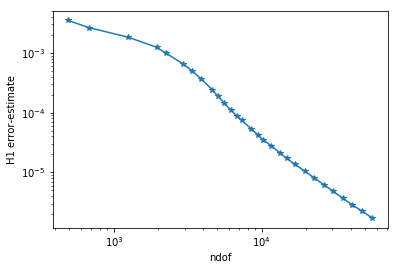

In [14]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show()